MULTIPOLYGON (((619.405939446995 226.27868762612343, 633.7658957673702 282.4292786652222, 640.8949527300429 310.6089758160524, 656.7969185822876 375.01412283303216, 703.4763331416762 511.49202171480283, 731.265168145299 575.7050880794413, 736.2772021543037 590.2864266138614, 1103.6257785307066 472.5480009979566, 1101.7909944863059 387.31454765610397, 1196.5975007070228 214.89662452833727, 1196.072588837822 161.41622501937672, 1191.5848234841833 145.12513330345973, 1184.0073621053016 81.73677017074078, 1172.7411235362524 50.74225845467299, 1154.6653157826513 -11.918737126979977, 1165.4615908572264 -100.94793101806678, 690.4323260284795 5.812780967010324, 619.405939446995 226.27868762612343)), ((-915.4730521376478 902.441579060629, -850.7128086669836 917.6225735140033, -762.0215256316587 925.9448589738458, -678.8306759487605 933.6798006002791, -659.9711500992998 920.9746357407421, -517.8380197745282 847.4232805357315, -539.0392299549421 693.777030960191, -199.71140990091953 536.563728439

AttributeError: 'MultiPolygon' object has no attribute 'exterior'

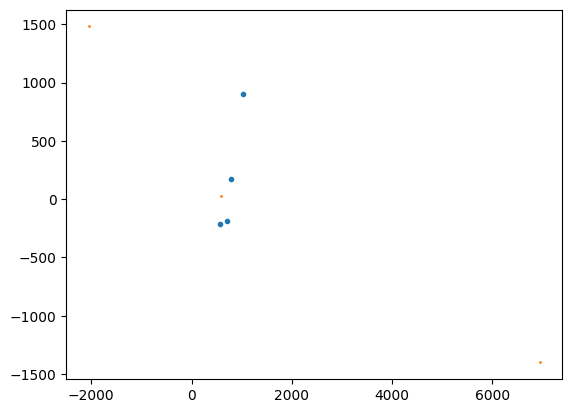

In [14]:
#!/usr/bin/env python3

import enum
from xxlimited import new
from matplotlib import axis
import numpy as np
from scipy.spatial import Voronoi
from scipy.spatial import ConvexHull, convex_hull_plot_2d
import matplotlib.pyplot as plt
import networkx as nx
from scipy._lib.decorator import decorator as _decorator
from yaml import Mark
import smallestenclosingcircle 
import statistics
import datetime
import xml.etree.ElementTree as ET
from math import *
import os
import shutil
from shapely.geometry import Polygon as Shapely_polygon
from shapely.geometry import LineString as Shapely_line
from shapely.geometry import Point as Shapely_point
from shapely.ops import split as Shapely_split
from shapely.ops import cascaded_union as Shapely_cascaded_union
import sys
import pandas as pd
import rospkg
import alphashape
import pickle

dirname = rospkg.RosPack().get_path('mrpp_sumo')


# graph_name = 'iitb_full'
# no_of_base_stations = 20

graph_name = 'iit_delhi2'
no_of_base_stations = 4


graph_path = dirname +'/graph_ml/'+ graph_name + '.graphml'
graph_results_path = dirname +'/scripts/algorithms/partition_based_patrolling/graphs_partition_results/'+ graph_name + '/' + str(no_of_base_stations) + '_base_stations/'
graph = nx.read_graphml(graph_path)
if os.path.exists(graph_results_path):
    shutil.rmtree(graph_results_path)
    os.makedirs(graph_results_path)
else:
    os.makedirs(graph_results_path)


__all__ = ['delaunay_plot_2d', 'convex_hull_plot_2d', 'voronoi_plot_2d_clip']


@_decorator
def _held_figure(func, obj, ax=None, **kw):
    import matplotlib.pyplot as plt  # type: ignore[import]

    if ax is None:
        fig = plt.figure()
        ax = fig.gca()
        return func(obj, ax=ax, **kw)

    # As of matplotlib 2.0, the "hold" mechanism is deprecated.
    # When matplotlib 1.x is no longer supported, this check can be removed.
    was_held = getattr(ax, 'ishold', lambda: True)()
    if was_held:
        return func(obj, ax=ax, **kw)
    try:
        ax.hold(True)
        return func(obj, ax=ax, **kw)
    finally:
        ax.hold(was_held)


def _adjust_bounds(ax, points):
    margin = 0.1 * points.ptp(axis=0)
    xy_min = points.min(axis=0) - margin
    xy_max = points.max(axis=0) + margin
    ax.set_xlim(xy_min[0], xy_max[0])
    ax.set_ylim(xy_min[1], xy_max[1])


@_held_figure
def delaunay_plot_2d(tri, ax=None):

    if tri.points.shape[1] != 2:
        raise ValueError("Delaunay triangulation is not 2-D")

    x, y = tri.points.T
    ax.plot(x, y, 'o')
    ax.triplot(x, y, tri.simplices.copy())

    _adjust_bounds(ax, tri.points)

    return ax.figure


@_held_figure
def convex_hull_plot_2d(hull, ax=None):

    from matplotlib.collections import LineCollection  # type: ignore[import]

    if hull.points.shape[1] != 2:
        raise ValueError("Convex hull is not 2-D")

    ax.plot(hull.points[:,0], hull.points[:,1], 'o')
    line_segments = [hull.points[simplex] for simplex in hull.simplices]
    ax.add_collection(LineCollection(line_segments,
                                     colors='k',
                                     linestyle='solid'))
    _adjust_bounds(ax, hull.points)

    return ax.figure


@_held_figure
def voronoi_plot_2d_clip(vor, ax=None, **kw):

    from matplotlib.collections import LineCollection

    if vor.points.shape[1] != 2:
        raise ValueError("voronoi diagram is not 2-D")
    
    if kw.get('show_points', True):
        point_size = kw.get('point_size', None)
        ax.plot(vor.points[:,0], vor.points[:,1], '.', markersize=point_size)
    if kw.get('show_vertices', True):
        ax.plot(vor.vertices[:,0], vor.vertices[:,1], 'o',markersize=1)

    line_colors = kw.get('line_colors', 'k')
    line_width = kw.get('line_width', 1.0)
    line_alpha = kw.get('line_alpha', 1.0)

    center = vor.points.mean(axis=0)
    ptp_bound = hull_points.ptp(axis=0)

    finite_segments = []
    Infinite_segments = []

    for pointidx, simplex in zip(vor.ridge_points, vor.ridge_vertices):
        simplex = np.asarray(simplex)
        if np.all(simplex >= 0):
            finite_segments.append(vor.vertices[simplex])
        else:
            i = simplex[simplex >= 0][0]  # finite end voronoi vertex

            t = vor.points[pointidx[1]] - vor.points[pointidx[0]]  # tangent
            t /= np.linalg.norm(t)
            n = np.array([-t[1], t[0]])  # normal

            midpoint = vor.points[pointidx].mean(axis=0)
            direction = np.sign(np.dot(midpoint - center, n)) * n
            if (vor.furthest_site):
                direction = -direction
            far_point = vor.vertices[i] + direction * ptp_bound.max()

            Infinite_segments.append([vor.vertices[i], far_point])
    
    

    final_regions = []
    for idx,point in enumerate(vor.points):
        # print(point,idx)
        enclosed_point_index = idx
        region_index = vor.point_region[enclosed_point_index]
        region_points_indices = vor.regions[region_index]
        
        if -1 not in region_points_indices:
            finite_region_index = vor.point_region[enclosed_point_index]
            finite_region_points_indices = vor.regions[finite_region_index]
            finite_region = vor.vertices[finite_region_points_indices]
            b = Shapely_polygon(finite_region.tolist())
            # plt.plot()
            print(hull.intersection(b))
            x,y = hull.intersection(b).exterior.coords.xy
            finite_region = np.column_stack((x,y))[:-1,:]
            final_regions.append(finite_region)

        else:
            # Finding regions of hull which cut the boundary regions
            
            Infinite_region_points_indices = region_points_indices
            while Infinite_region_points_indices.index(-1) !=0:
                Infinite_region_points_indices.append(Infinite_region_points_indices.pop(0))
            Infinite_region_points_indices.remove(-1)
            Infinite_region = vor.vertices[Infinite_region_points_indices]
            point_index = np.where(vor.points==point)[0][0]
            point_ridge_indices =np.where(vor.ridge_points==point_index)[0]
            ridge_segment_vertices = np.take(vor.ridge_vertices,point_ridge_indices,axis=0)
            
            for ridge_segment_vertex, m in zip(ridge_segment_vertices,range(ridge_segment_vertices.shape[0])):
            
                if -1 in ridge_segment_vertex:
                    pointidx = vor.ridge_points[point_ridge_indices[m]]
                    i = ridge_segment_vertex[ridge_segment_vertex >= 0][0]  # finite end voronoi vertex

                    t = vor.points[pointidx[1]] - vor.points[pointidx[0]]  # tangent
                    t /= np.linalg.norm(t)
                    n = np.array([-t[1], t[0]])  # normal

                    midpoint = vor.points[pointidx].mean(axis=0)
                    direction = np.sign(np.dot(midpoint - center, n)) * n
                    if (vor.furthest_site):
                        direction = -direction
                    far_point = vor.vertices[i] + direction * ptp_bound.max()
                    if np.where(Infinite_region==vor.vertices[i])[0][0] == 0:
                        Infinite_region = np.insert(Infinite_region,0,far_point,axis=0)
                    else:
                        Infinite_region = np.append(Infinite_region,[far_point],axis=0)
                  
            b = Shapely_line(Infinite_region.tolist())
            x,y = b.coords.xy
            color_list = ['r','g','c','b','m','k']
            c = Shapely_split(hull,b) 
            issue = True
            for poly in c.geoms:
                if poly.contains(Shapely_point(point)) or poly.intersects(Shapely_point(point)) or Shapely_point(point).distance(poly) < 1e-12:
                    x,y = poly.exterior.coords.xy
                    Infinite_region = np.column_stack((x,y))[:-1,:]
                    issue = False
            if issue: 
                print('Issue detected')
                for poly in c.geoms:
                    print(poly)
                    print(Shapely_point(point).distance(poly),Shapely_point(point).intersects(poly),poly.contains(Shapely_point(point)),poly.intersects(Shapely_point(point)))
                for idx,d in enumerate(c.geoms):
                    x,y = d.exterior.coords.xy
                    ax.plot(x,y,'-k',color=color_list[idx+1],linewidth=4-idx)
                    ax.plot(point[0],point[1],'*')
                x,y = b.coords.xy
                ax.plot(x,y,'-k',color=color_list[0],linewidth=1)
                plt.show()
                sys.exit()
            final_regions.append(Infinite_region)  #appending to final set of polygon and its seed

    ax.add_collection(LineCollection(finite_segments,
                                     colors=line_colors,
                                     lw=line_width,
                                     alpha=line_alpha,
                                     linestyle='solid'))
    ax.add_collection(LineCollection(Infinite_segments,
                                     colors=line_colors,
                                     lw=line_width,
                                     alpha=line_alpha,
                                     linestyle='dashed'))

    ax.plot(vor.points[:,0], vor.points[:,1], 'o',markersize=1.5)
    hull_x,hull_y = zip(*np.append(hull_points,[hull_points[0]],axis=0))
    ax.plot(hull_x, hull_y, 'k-')
   

    
    _adjust_bounds(ax, hull_points)
    return ax,np.array(final_regions,dtype=object)


def base_station_initial_points(boundary_poly,n):

    minx, miny, maxx, maxy = boundary_poly.bounds

    random_x = None
    random_y = None
    base_station_points = []
    for i in range(n):
        is_inside = False
        while not is_inside:
            # print('lol')
            random_x = np.random.uniform( minx, maxx, 1 )[0]
            random_y = np.random.uniform( miny, maxy, 1 )[0]
            # print(random_x,random_y,boundary_poly.contains(Shapely_point([random_x,random_y])))
            is_inside = boundary_poly.contains(Shapely_point([random_x,random_y]))
        base_station_points.append([random_x,random_y])
    return base_station_points


def get_boundary_hull(points):
    global hull, hull_points, hull_poly
    hull_path = dirname+'/graph_ml/'+graph_name+'_hull'
    if os.path.exists(hull_path):
        with open(hull_path, "rb") as poly_file:
            hull = pickle.load(poly_file)
    else:    

        # hull = ConvexHull(initial_points)
        hull =alphashape.alphashape(initial_points)
    
        with open(hull_path, "wb") as poly_file:
            pickle.dump(hull, poly_file, pickle.HIGHEST_PROTOCOL)

    hull_points=np.column_stack((hull.exterior.coords.xy)).tolist()
    hull_points = np.array(hull_points)
    hull_poly = Shapely_polygon(hull_points.tolist()) # Define Convex Hull Polygon

def save_data():
    global base_stations_df
    for idx,p in enumerate(new_base_points):
        covered_nodes = []
        for node,data in graph.nodes(data=True):
            dist = ((data['x']-p[0])**2+(data['y']-p[1])**2)**0.5
            if dist <= radii[idx] : covered_nodes.append(node)
        
        if covered_nodes !=[]:
            base_station_dic = {'location' : [p],'Radius': radii[idx], 'covered_nodes' : [covered_nodes], 'Total_nodes_covered' : len(covered_nodes)}
            base_stations_df = pd.concat([base_stations_df,pd.DataFrame(base_station_dic,index=[idx])])        

    base_stations_df.to_csv(graph_results_path + graph_name + "_with_"+str(no_of_base_stations) + '_base_stations.csv')
    np.save(graph_results_path + graph_name + "_with_"+str(no_of_base_stations) + '_base_stations.npy',new_base_points)




    
rng = np.random.default_rng(12345)
# old_points = rng.random((25, 2))
old_points = []

for node,data in graph.nodes(data=True):
    old_points.append(np.array((data['x'],data['y'])))

initial_points = old_points
get_boundary_hull(initial_points)

base_stations_df = pd.DataFrame()
new_base_points = None
radii = []

if no_of_base_stations ==1:
    x,y = hull.exterior.coords.xy
    region = np.column_stack((x,y))[:-1,:]
    c_x,c_y,r = smallestenclosingcircle.make_circle(region)
    new_base_points = [[c_x,c_y]]
    radii.append(r)
    save_data()
    sys.exit()

starting_base_points = base_station_initial_points(hull_poly,n=no_of_base_stations)
voronoi = Voronoi(starting_base_points)
new_base_points = starting_base_points
sd = 100
i = 0

cutoff = 0.3
rho_old = None
rho_new = None

while True:
    a = datetime.datetime.now()
    voronoi = Voronoi(new_base_points)
    previous_base_points = new_base_points
    plt_ax,cliped_regions = voronoi_plot_2d_clip(voronoi)

    new_base_points = []
    radii = []
    rho_old = rho_new
    for idx,region in enumerate(cliped_regions):
        c_x,c_y,r = smallestenclosingcircle.make_circle(region)
        # print(region)
        region_poly = Shapely_polygon(region)
        if region_poly.contains(Shapely_point([c_x,c_y])):
            new_base_points.append([c_x,c_y])
            # print('c',[c_x,c_y])
        else:
            # p = previous_base_points[idx]
            p = base_station_initial_points(region_poly,1)[0]
            new_base_points.append(p)
            # print('p',p)

        radii.append(r)
        enclosing_circle = plt.Circle(( c_x , c_y ), r ,fill=False,color='#34eb43')
        plt_ax.add_artist(enclosing_circle)
    # print(new_base_points)
    rho_new = int(max(radii))
    x_axis = np.array(radii)
    x_axis = np.sort(x_axis)
    mean = statistics.mean(x_axis)
    sd = statistics.stdev(x_axis)
    b= datetime.datetime.now()
    c= b-a
    # print(graph_name ,'Iteration',i,'rho_new:',rho_new,' rho_old:',rho_old, '#Base stations:',len(starting_base_points),'Iteration time(secs):',c.seconds)
    plt.gca().set_aspect('equal', adjustable='box')

    
    i+=1
    if rho_new is not None and rho_old is not None:
        if abs(rho_new-rho_old)/max(rho_new,rho_old) < 0.001:
            for node,data in graph.nodes(data=True):
                plt_ax.plot(data['x'],data['y'],'*',color='#FFD433') 
            plt.savefig(graph_results_path+'partition_stage.png')
            break
    plt.close('all')    
save_data()



In [19]:
from shapely.geometry import MultiPolygon
a = Shapely_polygon(619.405939446995 226.27868762612343, 633.7658957673702 282.4292786652222, 640.8949527300429 310.6089758160524, 656.7969185822876 375.01412283303216, 703.4763331416762 511.49202171480283, 731.265168145299 575.7050880794413, 736.2772021543037 590.2864266138614, 1103.6257785307066 472.5480009979566, 1101.7909944863059 387.31454765610397, 1196.5975007070228 214.89662452833727, 1196.072588837822 161.41622501937672, 1191.5848234841833 145.12513330345973, 1184.0073621053016 81.73677017074078, 1172.7411235362524 50.74225845467299, 1154.6653157826513 -11.918737126979977, 1165.4615908572264 -100.94793101806678, 690.4323260284795 5.812780967010324, 619.405939446995 226.27868762612343)
MultiPolygon(-915.4730521376478 902.441579060629, -850.7128086669836 917.6225735140033, -762.0215256316587 925.9448589738458, -678.8306759487605 933.6798006002791, -659.9711500992998 920.9746357407421, -517.8380197745282 847.4232805357315, -539.0392299549421 693.777030960191, -199.71140990091953 536.5637284396216, -554.6835648557171 671.3077723248862, -560.0481947228493 663.0614088372752, -936.6830554068686 870.7838932277468, -915.4730521376478 902.441579060629)), ((-166.5657417239854 507.6344595984556, 54.45501968730241 413.8670966178179, 36.63653733555261 333.9765367786089, -126.39305726610948 423.8909763456884, -166.5657417239854 507.6344595984556)

SyntaxError: invalid syntax (333074204.py, line 2)